# Q-Learning - Saving Sirius Black

    Reinforcement learning is an area of Artificial Intelligence that helps an agent perform determined actions in order to reach a particular goal. This method can have different applications such as dynamic treatment regimes(DTRs) and self-driving cars, and playing games.
    Reinforcment learning consists in having an agent that can be in different states, and perform certain actions in each given state. Performing an action in a given state results in a new state for the agent. The agent must have a state goal that can be reached by performing different actions, and the idea is to teach the agent how to reach the goal state, in other words, the agent must learn to make decisions regarding which action to take in each state, in order to reach the goal state in an efficient way. For the agent to learn, RL consists in giving points for each action the agent makes. These points are seen as rewards or penalization for the agent. The goal of the agent, therefore, is to maximize the reward, in order to learn to reach the goal. 
    The most important thing in the algorithm is the way it saves the information of which actions can have a good or bad reward, and which actions will really lead the agent to the goal state. The algorithm has a Q-table in order to store information of each state, and for each state the expected reward of each action the agent can take. This expected reward is a value that tells the agent how good or bad it is to take each of the possible actions it can perform. As the agent learns, these values change, until the agent reaches the point where the reward is maximized, and it cannot improve further. When this happens, the agent has reached an optimal policy. The optimal policy can be defined as the best possible actions the agent has to make in each state in order to maximize the reward. The main objective or RL is finding the optimal policy for the problem to be solved.
    For this practice, we will apply RL using Q-learning, to teach an agent representing Harry Potter to save Sirius Black. The scenario consists of a gameboard of 9 columns and 7 rows. Harry starts at position (1,1) and Sirius is on (7,4). In columns 3,4, and 5 there are strong winds going from south to north. 
    
 <img src="images/Reinforcement-Learning-Animation.gif">
    References:
    https://neptune.ai/blog/reinforcement-learning-applications

## PART 1: Explaining Implementation of Q-learning algorithm

#### Libraries used

In [7]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
from matplotlib import pyplot as plot
import numpy as np

#### Set up GAME ENVIRONMENT:
    1. STATE CLASS:
    State class represents a state in the game. A state represents a position in the game board, consisting of x and y:

In [8]:
class State:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    2. ACTION SPACE:
    There are 4 possible actions for Harry: move up, move down, move left, and move right. We define these actions as lambda functions that receive a State and return a new updated State by performing the corresponding action:
    The action space size is 4 as there are 4 possilbe actions, and the state space size is 63, since there are 9 columns and 7 rows in the game board matrix.

In [9]:
up = lambda state: State(state.x, state.y-1)
down = lambda state: State(state.x, state.y+1)
left = lambda state: State(state.x - 1, state.y)
right = lambda state: State(state.x + 1, state.y)
action_space_size = 4
state_space_size = 63
action_space = [up, down, left, right]

print(action_space_size,state_space_size)

4 63


    Testing actions:

In [10]:
a = State(1,1)
print(up(State(1,2)), down(a), left(a), right(a))

<__main__.State object at 0x00000215E977E490> <__main__.State object at 0x00000215E977ECD0> <__main__.State object at 0x00000215E977E400> <__main__.State object at 0x00000215E98F5C70>


##### Function get_sample:
    This function returns a random action from the action_space.

In [268]:
def get_sample():
    random_pos = np.random.randint(0,4)
    return action_space[random_pos], random_pos

###### Function get_num_state: 
    Each action has a corresponding identifier (integer). This function returns this identifier.

In [269]:
def get_num_state(state):
    return state.y*9 + state.x

In [270]:
get_num_state(State(8,6))

62

###### Function reset: 
    This function resets the game state, returning the initial state for Harry.

In [271]:
def reset():
    initial_state = State(1,1)
    return initial_state,get_num_state(initial_state)

###### Function is_goal_state: 
    Determines if the state is the goal state.

In [272]:
def is_goal_state(state):
    return state.x == 7 and state.y == 4

In [273]:
is_goal_state(State(7,4))

True

##### Function get_reward:
    Returns the reward for a given state:
    If state is out of range (out of the game board boundaries), reward is -10
    If state is goal state, reward is 126
    If state is any other state, reward is -1

In [274]:
def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return -10
    if is_goal_state(state):
        return 126
    return -1

In [275]:
get_reward(State(1,6))

-1

##### Function move:
    Performs an action in a given state, taking into account the wind probabilities for the game:
        wind_val is a dictionary containing the columns of wind as keys and the probability tresholds as values
    Returns the resulting state of performing the action on a given state, the reward of performing that action, and a boolean value, done, which is True if the game is over (if Harry gets out of the game board or reaches Sirius).
    If the action leads to the agent getting out of the game board, new_state will be None, because that position does not exist and is not present on the q-table.

In [276]:
wind_val = {3:0.1, 4:0.2, 5:0.15}

In [277]:
def move(state, action):
    new_state = action(state)
    wind_treshold = np.random.random()
    wind_prob = wind_val.get(new_state.x)
    if wind_prob:
        if wind_treshold < wind_prob:
            new_state.y -= 1
    reward = get_reward(new_state)
    done = is_goal_state(new_state) or reward == -10
    if reward == -10:
        new_state = None
    return new_state, reward, done

##### Initialize some parameters
    We will have 15000 episodes performed, with 100 steps of limit for one episode, to avoid infinite cycles.
    
### Running the algorithm:
###### VERSION 1: 
    - learning rate = 0.2
    - discount rate = 0.95

In [278]:
num_episodes = 15000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
#learning_rate = 0.8
#discount_rate = 0.99


rewards_avg = []

q_table = np.zeros((state_space_size, action_space_size))

#### Q-LEARNING Algorithm:
    This algorithm is based on the Frozen-lake lab algorithm. It performs 15000 episodes, 100 times in order to view the average of the 100 times and verify if the agent is really learning to maximize its reward.
    We are taking into account that when the agent gets out of the game board (meaning new_state = None when performing move function), the new state will be the prior state. This is based on analizing the way the Frozen-lake lab handled the same case. If this is not done, q-table would try to find a value out of range when updating.

In [281]:
# This cycle is to calculate the average reward/episodes and its only purpose is to plot the nice graph below that
# shows how the agent learns to maximize the reward.
rewards_avg = []
q_table_avg = []
for it in range(100):
    print('average ', it)
    rewards_all_episodes=[]
    q_table_all_episodes = []
    
    # exporation-exploitation trade-off params
    exploration_rate = 1
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005
    
    # init q table in zeros
    q_table = np.zeros((state_space_size, action_space_size))

    # iterate over the episodes
    for episode in range(num_episodes):
        state, num_state = reset()
        done = False
        rewards_current_episode = 0
        
        # iterate over the steps for an episode
        for step in range(max_steps_per_episode):
            # Exploration-exploitation trade-off
            exploration_rate_threshold = np.random.random()
            if exploration_rate_threshold <= exploration_rate:
                action, pos_action = get_sample()
            else:
                q_row = q_table[num_state]
                pos_action = np.where(q_row == max(q_row))[0][0]
                action = action_space[pos_action]
            # Take action
            new_state, reward, done = move(state, action)
            if new_state == None:
                num_new_state = get_num_state(state)
            else:
                num_new_state = get_num_state(new_state)
            # Update Q-table for Q(s,a)
            max_value = max(q_table[num_new_state])
            future_q=learning_rate*(reward + discount_rate*max_value)
            q_table[num_state, pos_action] = (1-learning_rate)*q_table[num_state,pos_action] + future_q
            
            # transition next state
            state = new_state
            num_state = num_new_state
            rewards_current_episode += reward

            if done == True: 
                break

        # Exploration rate decay
        exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate*episode)

        rewards_all_episodes.append(rewards_current_episode)
        q_table_all_episodes.append(q_table)
    rewards_avg.append(rewards_all_episodes)
    q_table_avg.append(q_table_all_episodes)

average  0
average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
av

#### Plotting Episodes Vs Reward
    We can observe how the agent learns to maximize its reward:

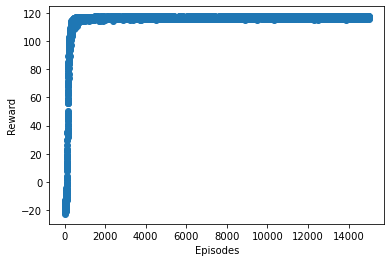

In [282]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

#### Visualizing Optimal Policy:
    Each number of the resulting matrix represents the best action for each corresponding state:
        0 -> UP
        1 -> DOWN
        2 -> LEFT
        3 -> RIGHT

In [285]:
#action_space = [up, down, left, right]  
state_best_actions =[]
arrow_matrix = []
for i in range(q_table.shape[0]):
    max_pos = np.argmax(q_table[i])
    state_best_actions.append(max_pos)
arrow_matrix = np.array(state_best_actions).reshape(7,9)

#### Visualizing with arrows:
    To have a better view, we graph with arrows:

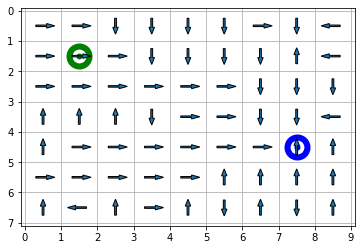

In [286]:
import matplotlib.pyplot as plt
best_actions_matrix = np.array(state_best_actions).reshape(7,9)
w = 0.3
arrow_dict = {0:lambda i,j:plt.arrow(x=i, y=j-0.25, dx=0, dy=w, width=.05)  ,1:lambda i,j:plt.arrow(x=i, y=j+0.25, dx=0, dy=-w, width=.05),2:lambda i,j:plt.arrow(x=i+0.2, y=j, dx=-w, dy=0, width=.05),3:lambda i,j:plt.arrow(x=i-0.2, y=j, dx=w, dy=0, width=.05)}
i,j=0,0
arrow_matrix=np.transpose(np.array(arrow_matrix).reshape(7,9))
for j in range(len(arrow_matrix)):
    for i in range(len(arrow_matrix[j])):
#         print(i,j)
        arrow_dict[best_actions_matrix[i,j]](j+0.5,(6-i)+0.5)
start = [1,1]
goal = [7,4]
plt.scatter(start[0]+0.5,6-start[1]+0.5, color="green", linewidths=20)
plt.scatter(goal[0]+0.5,6-goal[1]+0.5, color = "blue",linewidths=20)

plt.xticks(np.arange(9,-1, -1))
plt.yticks(np.arange(7,-1, -1),labels= ["0","1","2","3","4","5","6","7"])
plt.grid()
# display plot 
plt.show()

    As we can see above, as there are winds, meaning there is high probability of getting out of the game board if the agent is near the top border(row 0), we see that the arrow of the 3 columns (3,4,5) in row 0 and 1 are downards. This guarantees that the agent does not get out of the game board, and it leads to the goal state.

In [288]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[-7.35600717e+00 -3.00502700e+00 -8.75963162e+00  1.71729575e+00]
 [-9.63688856e+00  1.12697562e+01 -2.37257668e+00  6.89324121e+01]
 [ 1.29943832e+01  7.41629779e+01  4.85765556e+00  1.88758280e+01]
 [-1.78879237e+00  7.84139074e+01  2.14577908e+01  3.29249770e+01]
 [-6.07680819e+00  8.28442101e+01  1.01716231e+01 -6.83120000e-01]
 [-4.94840000e+00  8.18891877e+01 -5.93716000e-01 -7.71120000e-01]
 [-3.60000000e+00 -6.59760000e-01 -5.25056800e-01 -4.88000000e-01]
 [-2.00000000e+00 -2.00000000e-01 -2.50996000e-01 -2.00000000e-01]
 [-2.00000000e+00 -2.00000000e-01  0.00000000e+00  0.00000000e+00]
 [-2.88233834e+00  1.82549767e+01 -1.06823458e+01  6.96917878e+01]
 [ 6.37926213e+01  7.38903135e+01  6.51141291e+01  7.39367889e+01]
 [ 6.34549603e+01  6.02895815e+01  6.15085292e+01  7.87780986e+01]
 [ 7.09907867e+01  8.38600652e+01  7.30438418e+01  8.12166313e+01]
 [ 4.70466059e+01  9.18059838e+01  7.08945331e+01  6.55576236e+01]
 [ 5.20505268e+01  9.68353863e+01  

## WITHOUT WIND

In [254]:
def move_without_wind(state, action):
    #print(action)
    new_state = action(state)
    #print(new_state.x)
    reward = get_reward(new_state)
    #print(state.x, state.y , "r = ",reward)
    done = is_goal_state(new_state) or reward == -10
    if reward == -10:
        new_state = None
    return new_state, reward, done

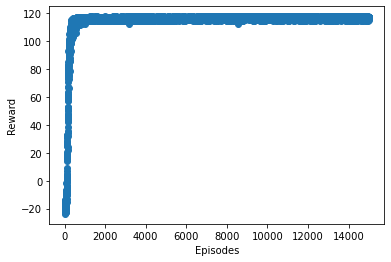

In [256]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

## PART 2: Answering the Questions Proposed:

1. ¿Cómo planeas penalizar y premiar al agente? 
    How do you plan to penalize and reward the agent?
    
        For this part, we made some experiments in order to view how the way of penalizing and rewarding the agent impacted on the learning effect of the agent. We tried 4 ways of penalizing the agent:
    
       1 Our first way of rewarding the agent was:
            a) -10 points if the agent gets out of the gameboard
            b) 126 points if the agent reaches the goal state
            c) -1 point for every step the agent makes
        We decided to give 126 points for the agent know it has to reach the goal to maximize the reward (126 is 2 times 63, which is the number of boxes in the gameboard), and we decided to penalize every step the agent makes, for the agent to find the most efficient path.
        
       2 Our second way of rewarding the agent will be:
            a) -10 points if the agent gets out of the gameboard
            b) 260 points if the agent reaches the goal state
            c) 2 points for every step the agent makes
        Here tried to see what happened if a positive reward is given for each step the agent makes. Will it be able to find the optimal path?
        
       3 Our third way of rewarding the agent will be:
            a) 0 points if the agent gets out of the gameboard
            a) 1 point if the agent reaches the goal state
            a) 0 points for every step the agent makes
        This way of rewarding is based on the lab practice for the Frozen Lake exercise, in which we identified that the agent got 0 reward when falling to a hole or getting out of the gameboard, and 1 of reward when reagching the goal state.
        
       4  Our fourth way of rewarding the agent will be:
            a) -1 points if the agent gets out of the gameboard
            b) 1 point if the agent reaches the goal state
            c) 0 points for every step the agent makes
            
       The experiments made for this part and results obtained can be found on Experiments-Rewards folder.
       The best way of penalizing and rewarding the agent proved to be our **version 1**.

2. Encuentra el optimal policy y grafica el average reward over time. Find the optimal policy and plot the average over time.
        
        In order to find the optimal policy, by using the first way of rewarding mentioned above, we performed different experiments varying the algorithm's parameters such as learning rate, discount rate, min_exploration_rate, max_exploration_rate, and exploration_decay_rate. The experiments made and results obtained can be found in the Experiments-Parameters folder, in the Experiments-Saving-Sirius-Black-With-Wind notebook. We performed 11 experiments. The agent learned faster in version 11, with the following combination of parameters:
           - learning rate: 0.20	
           - discount rate: 0.95
           - min_exploration_rate: 0.003	
           - max_exploration_rate: 1
           - exploration_decay_rate: 0.500	
         With this combination of parameters, the agent was able to learn to reach the goal state in an average of 55 episodes, and was able to reach the goal in 97.83% of the 2000 episodes performed. This is a good indicator for us. 
         The optimal policy will show the best actions the agent should choose in every step it makes in order to reach the goal state in an optimal way, maximizing the expected return.
         
        The comparation of the learning curve of the 4 best results of the experiments made is shown below:

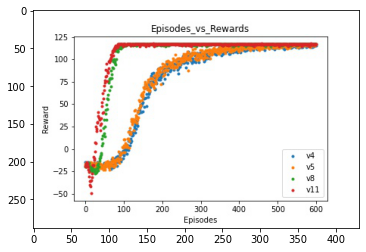

In [2]:
import matplotlib.pyplot as plt
img_name = "Experiments-Parameters/episodes_vs_reward/comparation_v45811.jpg"
img1 = plt.imread(img_name)
plt.imshow(img1)

    The optimal policy for the best experiment (version 11) is: 

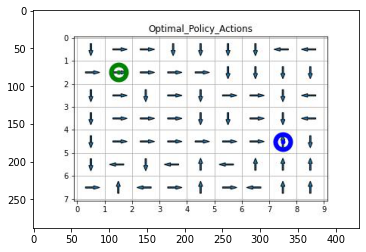

In [3]:
img = plt.imread('Experiments-Parameters/optimal_policies/v11.jpg')
plt.imshow(img)

    As we can see, the agent takes the best possible actions in order to reach the goal state effectively. As there can be wind form South to North in columns 3, 4, and 5, the agent prevents getting penalized (getting out of the gameboard) by having the actions in these 3 columns in row 0 pointing DOWN. This way, even if there is wind, the agent won't be able to get out of the gameboard. This guarantees the agent finding the goal state.

3. ¿Qué sucede si no hay vientos? ¿Cómo luce el optimal policy y el average reward over time? Comenta tus resultados.
    What happens if there are no winds? How does the optimal policy and average reward over time look? Comment your results.
    
        For this part, we took the 4 best parameter combinations of the prior experiments made considering wind effects, and tried them without considering wind. We got similar results for the 4 experiments, with experiment 4 (using parameters from prior version 11 which was the best experiment) being the best too. In general, the agent was able to learn a bit faster, due to the fact that it did not consider wind effects. Without wind, the agent learned easier than before.
            The experiments made and results obtained can be found in the Experiments-Parameters folder, in the Experiments-Saving-Sirius-Black-With-NO-Wind notebook. The agent learned faster in version 4, with the following combination of parameters:
        - learning rate: 0.20    
        - discount rate: 0.95
        - min_exploration_rate: 0.003    
        - max_exploration_rate: 1
        - exploration_decay_rate: 0.500    
        
          With this combination of parameters, the agent was able to learn to reach the goal state in an average of 49 episodes, and was able to reach the goal in 98.32% of the 2000 episodes performed. This is a good indicator for us. 
          The optimal policy will show the best actions the agent should choose in every step it makes in order to reach the goal state in an optimal way, maximizing the expected return.

         The comparation of the learning curve of the 4 experiments made is shown below:

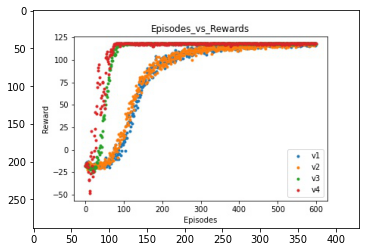

In [4]:
img_name = "Experiments-Parameters/episodes_vs_reward/comparation_no_wind.jpg"
img1 = plt.imread(img_name)
plt.imshow(img1)

The optimal policy for the best experiment (version 4) is: 

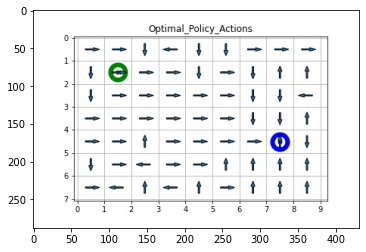

In [5]:
img = plt.imread('Experiments-Parameters/optimal_policies/v4_wnw.jpg')
plt.imshow(img)

    As we saw in experiments with wind, a bigger exploration decay rate helps the agent learn faster.
    We also osbserve that columns 4 and 5 in row 0 have the best action as DOWN too, but column 3 chooses left. Since there is no wind, and the agent would not get out of the gameboard by going left, it can still be considered an optimal action. Truly, if there is no wind, the agent would not even reach column 3 in row 0, it would just follow the path following the arrows from Harry (green circle) to Sirus (blue circle), which is an optimal path since it finds the goal state in the minimum possible amount of steps.

    Now we will compare the best experiments'episodes_vs_rewards and optimal policies obtained with and without wind:
  #### Episodes vs Rewards Wind vs No Wind

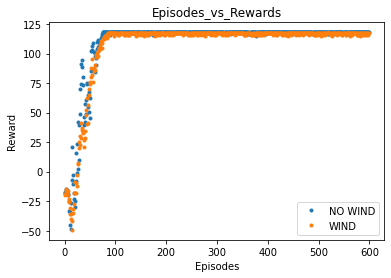

In [13]:
def load_rewards(filename):
    rewards_avg =np.load(filename)
    return rewards_avg

r_v4 = load_rewards("Experiments-Parameters/rewards/rewards_v4_wnw.npy")
r_v11  = load_rewards("Experiments-Parameters/rewards/rewards_v11.npy")

x = [i for i in range(0,600)]
y_v4 = np.mean(r_v4, axis=0)[:600]
y_v11 = np.mean(r_v11, axis=0)[:600]

plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y_v4,'.')
plot.plot(x, y_v11,'.')

plot.title("Episodes_vs_Rewards")
plt.legend(['NO WIND','WIND'])
plt.savefig("Experiments-Parameters/episodes_vs_reward/comparation_wind_no_wind.jpg")
plt.show()

    We observe that the learning curve for the best experiments with and without wind are very similar, the best experiment with no wind showing a tiny advantage in learning rate. This tiny advantage si due to the fact that the agent does not have to deal with winds and can find a straight path towards the goal state, without dealing with an external force. As for the reason for the advantage to be tiny and not big, we think this is because there is wind only on 3 columns, and the probabilities of wind are really small, so they do not have a really big impact on the agent.
    

  #### Optimal Policies Wind vs No Wind

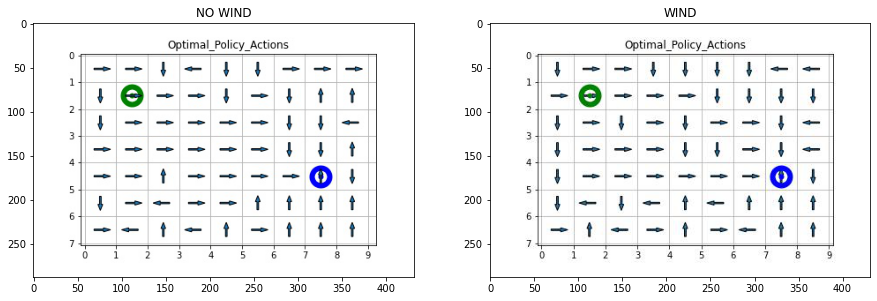

In [16]:
img1 = plt.imread('Experiments-Parameters/optimal_policies/v4_wnw.jpg')
img4 = plt.imread('Experiments-Parameters/optimal_policies/v11.jpg')

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('NO WIND')

plt.subplot(1,2,2)
plt.imshow(img4)
plt.title('WIND')
plt.show()


plt.show()

    Comparing the optimal policies for the best experiments with and without wind, we can see small differences, but both agents guarantee to reach the goal in an optimal way and maximize the reward.
    Even though the agent in the scenario where there is no wind does not have to deal with wind in columns 3, 4, and 5, the best actions for columns 4 and 5 are still DOWN, because the agent is still penalized for getting out of the gameboard, which is an illegal action. 